In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Apr 13 22:12:54 2021

@author: pmarc
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn import metrics as mt
import statsmodels.api as sm
import scipy.stats as sts
import math


/tmp/ipykernel_214024/690754883.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X=donnee.drop({'Espèces','Poids (g)'}, 1)
/tmp/ipykernel_214024/690754883.py:17: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X2=X.drop({'Longueur 2 (cm)','Épaisseur (cm)'}, 1)


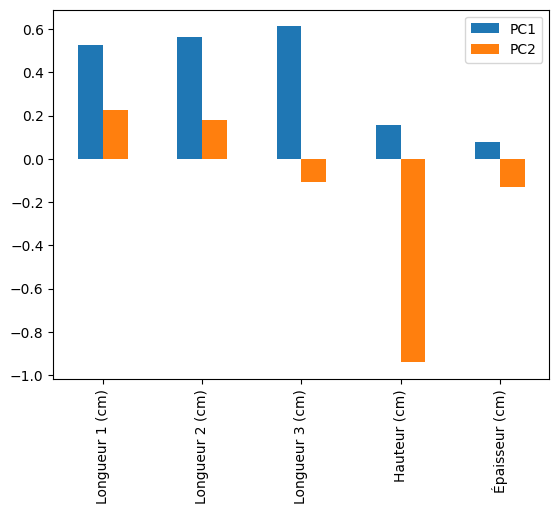

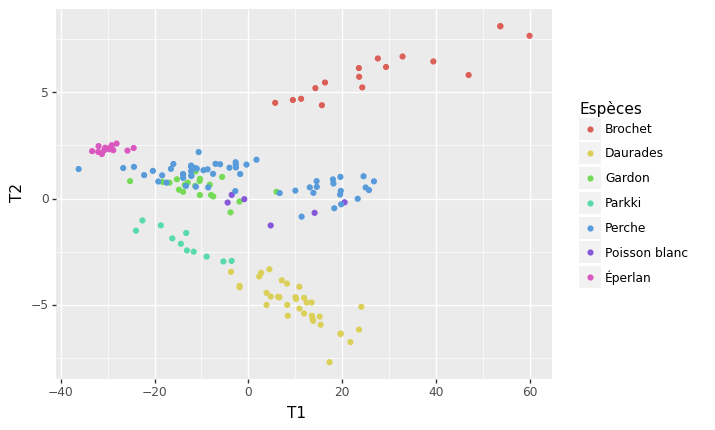

In [2]:

donnee = pd.read_csv('../../04_Eda/13/Fichiers/Poissonsv0r2.csv')
stats=donnee.describe()
dimensions=donnee.shape
nomsvariables = pd.DataFrame(donnee.columns)

X=donnee.drop({'Espèces','Poids (g)'}, 1)
Y=donnee['Poids (g)']
Yclass=donnee['Espèces']

"Ronde 1"
modele=sm.OLS(Y,X.assign(const=1))
resultats=modele.fit()
Y_chap = resultats.predict(X.assign(const=1))
resultats.summary()

"Ronde 2"
X2=X.drop({'Longueur 2 (cm)','Épaisseur (cm)'}, 1)
modele=sm.OLS(Y,X2.assign(const=1))
resultats=modele.fit()
Y_chap = resultats.predict(X2.assign(const=1))
resultats.summary()

"%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%"
"PCA"

from scipy import linalg
X_mean=X.mean()
X_std=X.std()
X_cent=X-X.mean().T
Lambdas,PT =linalg.eig(np.dot(X_cent.T,X_cent))
P=PT.T
VarianceCapturee=np.real(Lambdas/(Lambdas.sum()))

P1=P[0,:].reshape(1,-1)
P2=P[1,:].reshape(1,-1)
T=np.dot(X_cent,P.T)
T1_test=np.dot(X_cent,P1.T)
T2_test=np.dot(X_cent,P2.T)
T1=T[:,0]
T2=T[:,1]
Xest=np.dot(T,P)+X_mean.values.reshape(-1,1).T

P2,E2,P_mat2 =linalg.svd(X_cent)
P1v2=P_mat2[0,:]

"Directement des fonctions"

from sklearn.decomposition import PCA
a=2
pca = PCA(n_components=a)
pca.fit(X)
VarianceCapturee=pca.explained_variance_ratio_
X_pca_mean=pca.mean_
T=pca.transform(X)
P=pca.components_


T1=np.dot((X.values-X_pca_mean),P[0,:])
T2=np.dot((X.values-X_pca_mean),P[1,:])
Xest=pca.inverse_transform(T)


TPanda=pd.DataFrame(T)
TPanda.index=X.index
TPanda.columns=['T1','T2']
T_resultats=pd.concat([TPanda,Yclass],axis=1)

PPanda=pd.DataFrame(P.T)
PPanda.index=X.columns
PPanda.columns=['PC1','PC2']

PPanda.plot.bar()

import plotnine as p9
graph = p9.ggplot(data=T_resultats,
           mapping=p9.aes(x='T1', y='T2', color='Espèces'))
print(graph + p9.geom_point())


In [4]:


"PCR"

CORRMAT=TPanda.corr()
modele=sm.OLS(Y,TPanda.assign(const=1))
resultats=modele.fit()
Y_chap = resultats.predict(TPanda.assign(const=1))
resultats.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Poids (g)   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     529.2
Date:                Thu, 16 Mar 2023   Prob (F-statistic):           3.06e-70
Time:                        19:30:45   Log-Likelihood:                -996.96
No. Observations:                 159   AIC:                             2000.
Df Residuals:                     156   BIC:                             2009.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
T1            17.4837      0.542     32.242      0.000      16.413      18.555
T2           -13.3777      3.089     -4.331      0.000     -19.479      -7.277
const        398.3264     10.240     38.897      0.000     378.099     418.554
==============================================================================
Omnibus:                        4.093   Durbin-Watson:                   0.431
Prob(Omnibus):                  0.129   Jarque-Bera (JB):                3.650
Skew:                           0.354   Prob(JB):                        0.161
Kurtosis:                       3.220   Cond. No.                         18.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

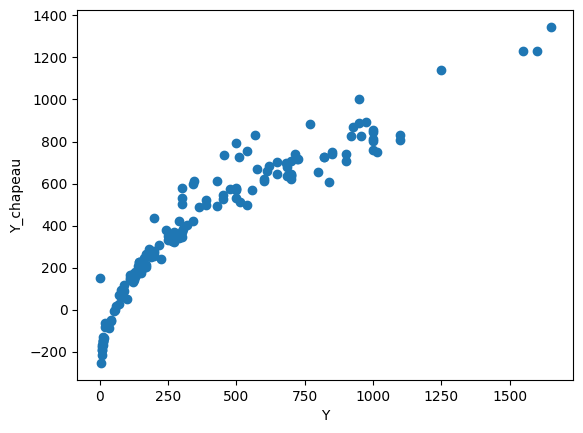

In [5]:

Betas=resultats.params
Betasfinaux=np.dot(Betas[0:2],P).reshape(-1,1)
BetasfinauxPanda=pd.DataFrame(Betasfinaux)
BetasfinauxPanda.index=X.columns
ordonnee=pd.Series(Betas[2])
ordonnee.index=['Beta0']
BetasfinauxPanda=pd.concat([BetasfinauxPanda,ordonnee],axis=0)
BetasfinauxPanda.columns=['Betas']

Ypix_chap=np.dot(((X-X_pca_mean).assign(const=1)).values,BetasfinauxPanda.values)
plt.scatter(Y, Y_chap)
plt.xlabel("Y")
plt.ylabel("Y_chapeau")
plt.show()
Y_chap=pd.DataFrame(Ypix_chap)
R2=np.corrcoef(Y.T,Y_chap.T)[0,1]


#Ypix_chap.index=Ypix.index



